In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

## Breast cancer classification

In [3]:
features_names = ['radius', 'texture', 'perimeter', 'area', 'smoothness','compactness',
                  'concavity', 'concave_points', 'symmetry', 'fractal_dimension']
suffixes = ['mean', 'se', 'worst']

column_names = []
for suffix in suffixes:
    for feature_name in features_names:
        column_names.append(feature_name + '_' + suffix)

In [4]:
data = pd.read_csv('wdbc.data', header=None, names=['id', 'target'] + column_names)

In [5]:
data.head()

,id,target,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
data = data.iloc[:, 1:]

### Data exploration

First of all I'd like to have a look at the data: how features distributed, relationships between them and a target variable and so on.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
target                     569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave_points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave_points_se          569 n

In [8]:
data['target'].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: target, dtype: float64

In [9]:
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [10]:
data.describe().loc['min', :].min()

0.0

So there are no missing values, all features are continuous and non-negativa, the features have different scales and target classes are imbalanced.

In [11]:
def plot_kde_by_classes(feature_name, ax):
    sns.kdeplot(data[data['target'] == 'M'][feature_name].values, label='M', ax=ax)
    sns.kdeplot(data[data['target'] == 'B'][feature_name].values, label='B', ax=ax)
    sns.kdeplot(data[feature_name].values, label='all', ax=ax)

In [12]:
def plot_boxplotes(feature_name):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
    sns.boxplot(y="{}_mean".format(feature_name), x="target", data=data, ax=ax1)
    sns.boxplot(y="{}_worst".format(feature_name), x="target", data=data, ax=ax2)
    sns.boxplot(y="{}_se".format(feature_name), x="target", data=data, ax=ax3)

In [13]:
def plot_kdes(feature_groupname):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
    
    plot_kde_by_classes('{}_mean'.format(feature_groupname), ax1)
    plot_kde_by_classes('{}_mean'.format(feature_groupname), ax2)
    plot_kde_by_classes('{}_mean'.format(feature_groupname), ax3)
    
    ax1.set_xlabel('{}_mean'.format(feature_groupname))
    ax2.set_xlabel('{}_worst'.format(feature_groupname))
    ax3.set_xlabel('{}_se'.format(feature_groupname))

    plt.legend();

Let's look at features distributions.

#### Raduis features

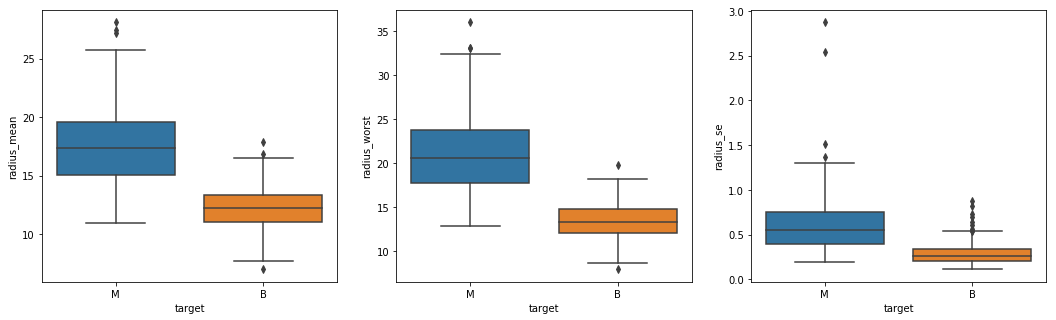

In [14]:
plot_boxplotes('radius')

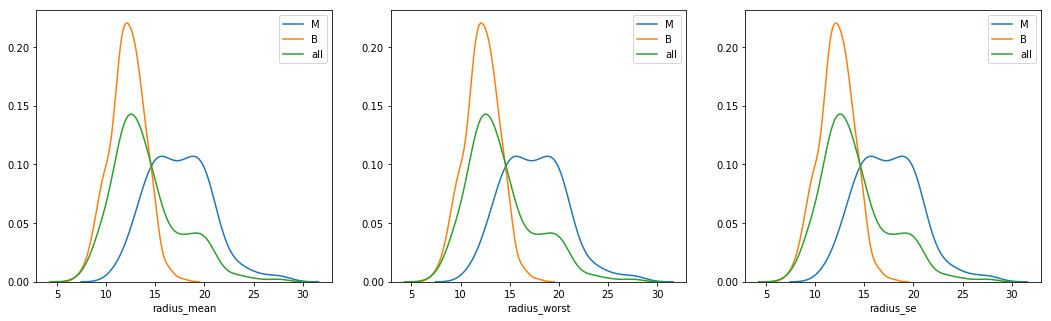

In [15]:
plot_kdes('radius')

#### Texture features

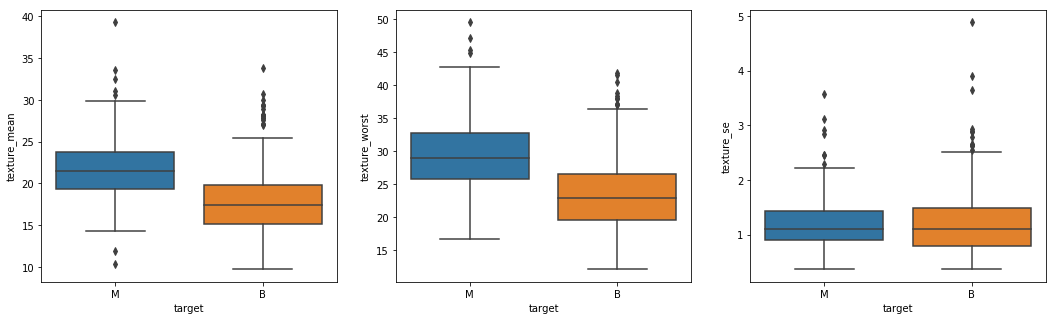

In [16]:
plot_boxplotes('texture')

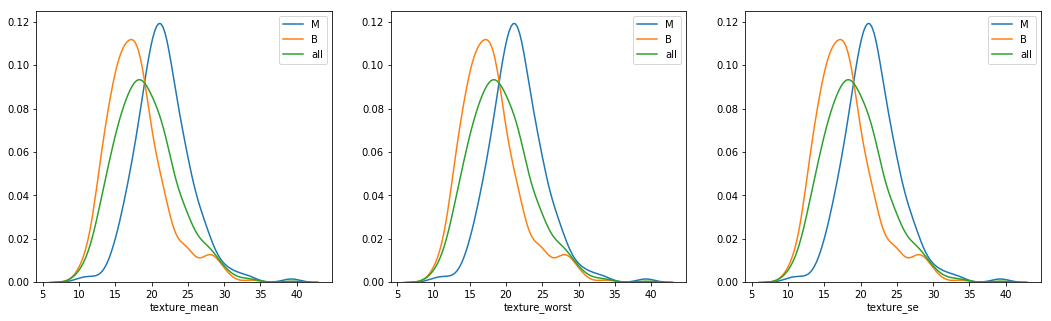

In [17]:
plot_kdes('texture')

#### Perimeter features

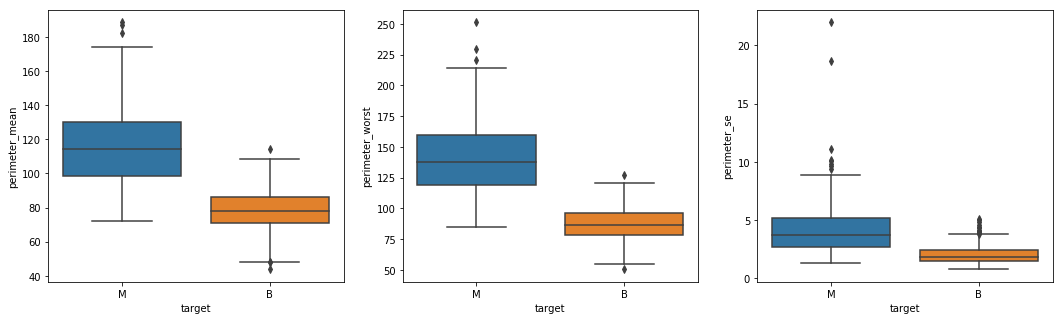

In [18]:
plot_boxplotes('perimeter')

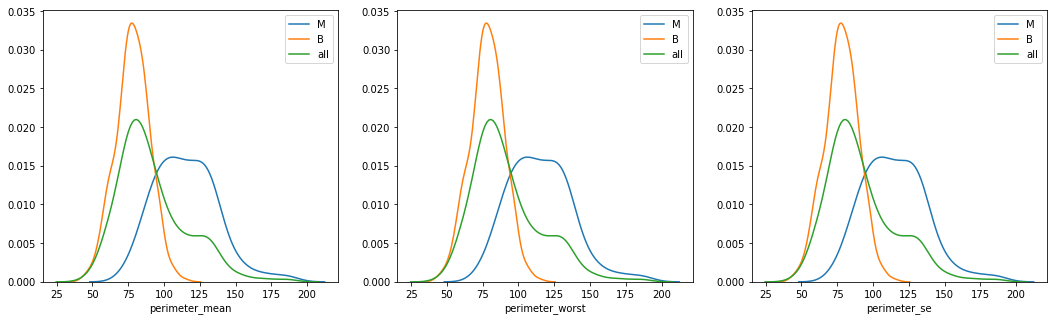

In [19]:
plot_kdes('perimeter')

#### Area features

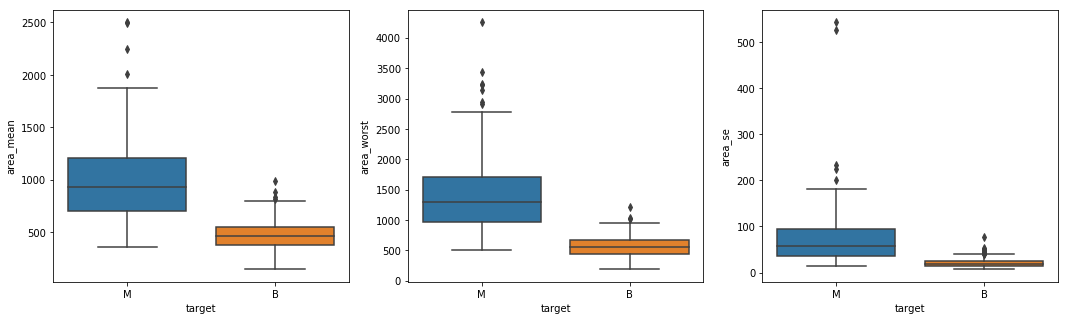

In [20]:
plot_boxplotes('area')

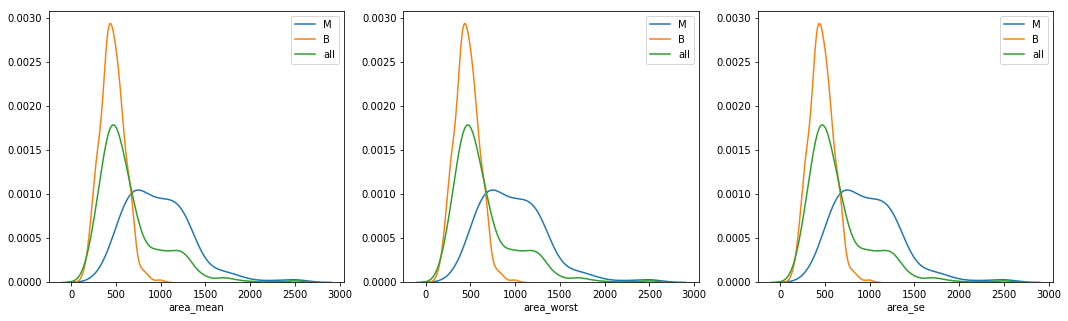

In [21]:
plot_kdes('area')

#### Smoothness features

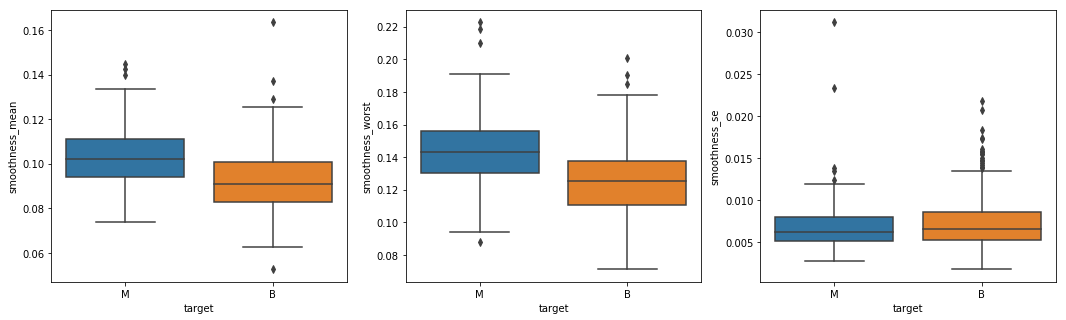

In [22]:
plot_boxplotes('smoothness')

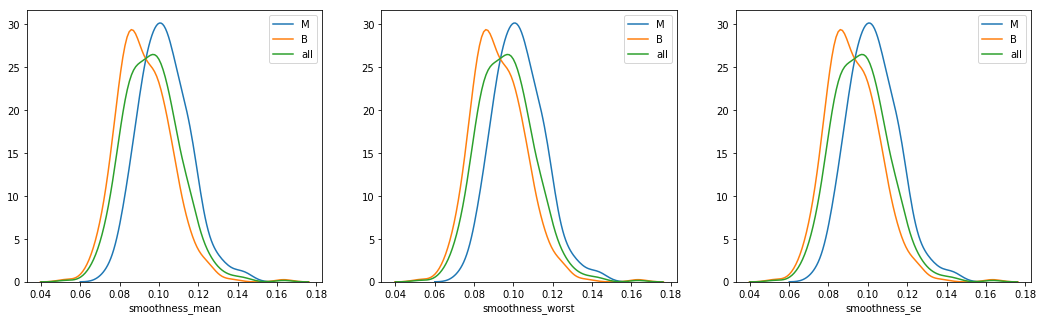

In [23]:
plot_kdes('smoothness')

#### Compactness features

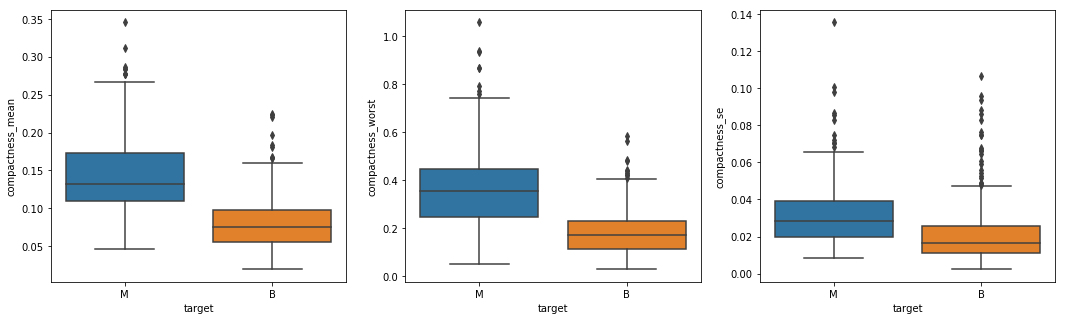

In [24]:
plot_boxplotes('compactness')

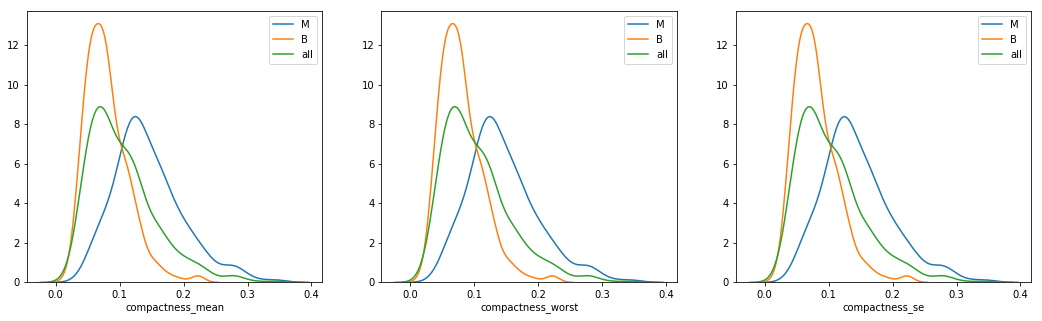

In [25]:
plot_kdes('compactness')

#### Concavity features

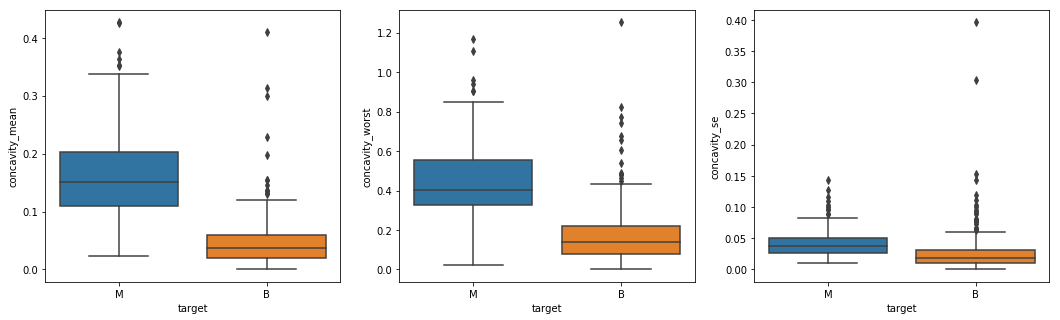

In [26]:
plot_boxplotes('concavity')

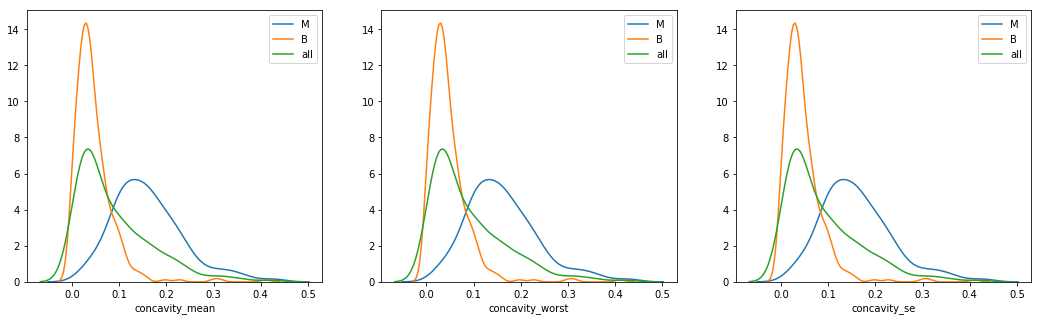

In [27]:
plot_kdes('concavity')

#### Concave points features

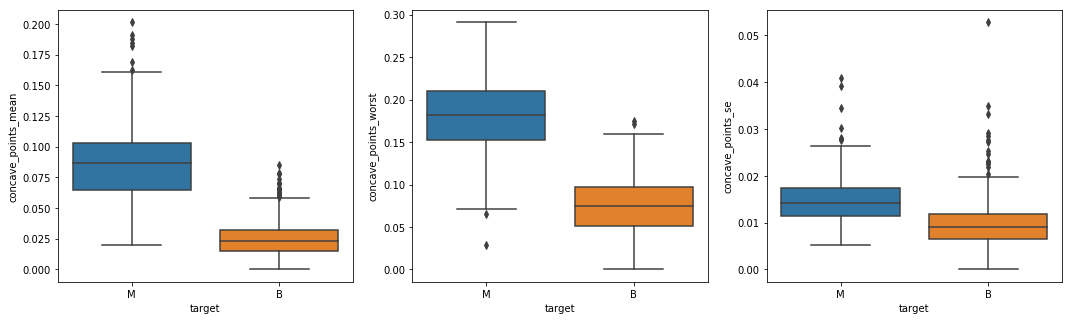

In [28]:
plot_boxplotes('concave_points')

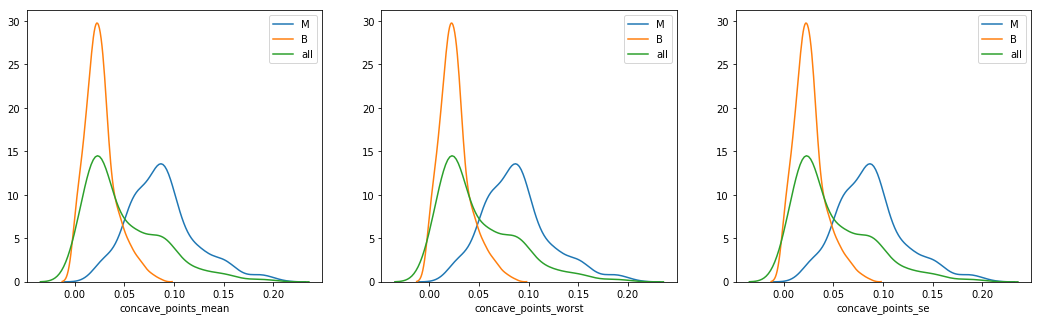

In [29]:
plot_kdes('concave_points')

#### Symmetry features

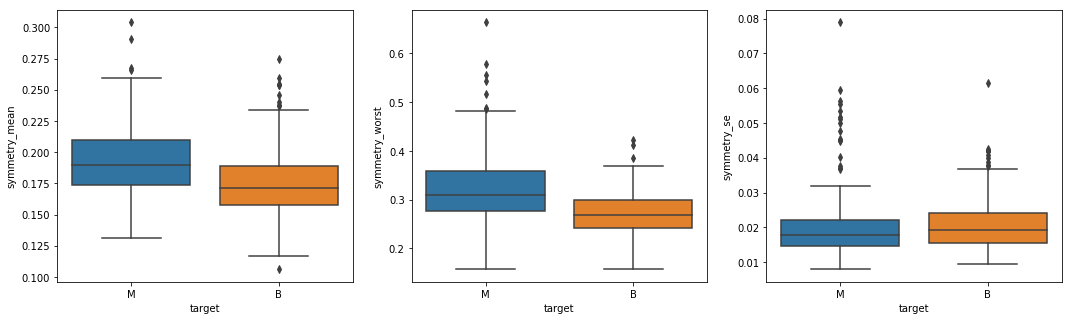

In [30]:
plot_boxplotes('symmetry')

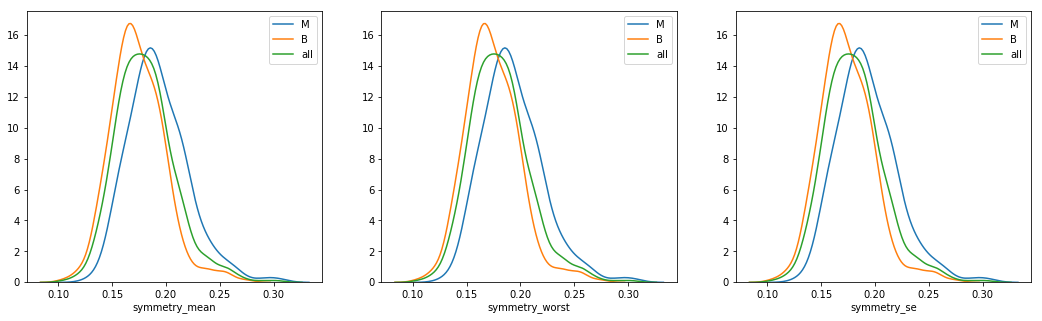

In [31]:
plot_kdes('symmetry')

#### Fractal dimension features

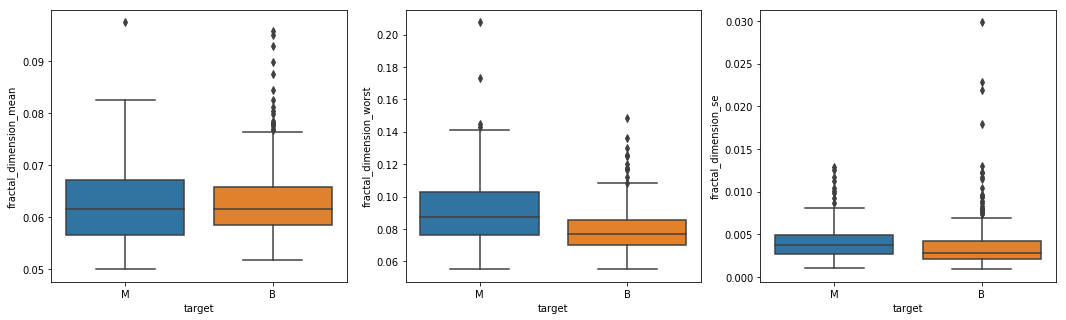

In [32]:
plot_boxplotes('fractal_dimension')

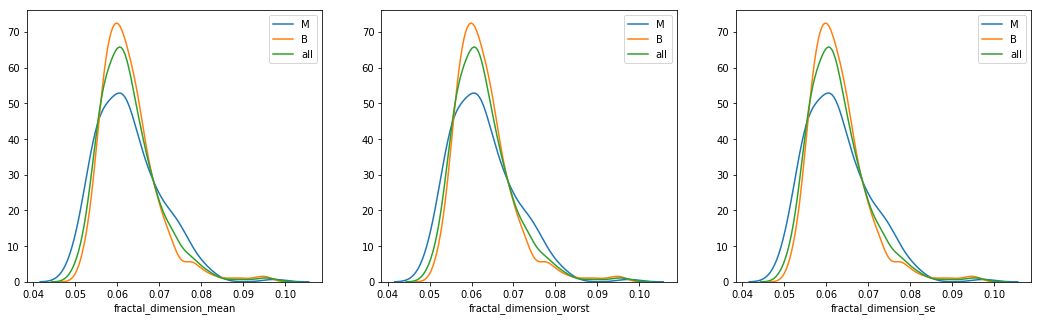

In [33]:
plot_kdes('fractal_dimension')

It seems that some features (e.g. fractal dimension features, symmetry features...) are irrelevant and others (e.g. area featues, concave points features, area features...) are quite important.

#### Feature correlation

I think that features in one "group" (mean, se and worst of cell features, e.g. radius_mean, radius_se and radius_worst) would be correlated, especially mean and worst features.

In [34]:
def show_correlation_matrix_group(feature_groupname):
    df = data[[feature_groupname + '_mean', feature_groupname + '_worst', feature_groupname + '_se']]
    corr = df.corr()
    return corr

In [35]:
show_correlation_matrix_group('radius')

,radius_mean,radius_worst,radius_se
radius_mean,1.000000,0.969539,0.679090
radius_worst,0.969539,1.000000,0.715065
radius_se,0.679090,0.715065,1.000000


In [36]:
show_correlation_matrix_group('texture')

,texture_mean,texture_worst,texture_se
texture_mean,1.000000,0.912045,0.386358
texture_worst,0.912045,1.000000,0.409003
texture_se,0.386358,0.409003,1.000000


In [37]:
show_correlation_matrix_group('area')                 

,area_mean,area_worst,area_se
area_mean,1.000000,0.959213,0.800086
area_worst,0.959213,1.000000,0.811408
area_se,0.800086,0.811408,1.000000


In [38]:
show_correlation_matrix_group('smoothness')

,smoothness_mean,smoothness_worst,smoothness_se
smoothness_mean,1.000000,0.805324,0.332375
smoothness_worst,0.805324,1.000000,0.314457
smoothness_se,0.332375,0.314457,1.000000


In [39]:
show_correlation_matrix_group('compactness')

,compactness_mean,compactness_worst,compactness_se
compactness_mean,1.000000,0.865809,0.738722
compactness_worst,0.865809,1.000000,0.678780
compactness_se,0.738722,0.678780,1.000000


In [40]:
show_correlation_matrix_group('concavity')

,concavity_mean,concavity_worst,concavity_se
concavity_mean,1.000000,0.884103,0.691270
concavity_worst,0.884103,1.000000,0.662564
concavity_se,0.691270,0.662564,1.000000


In [41]:
show_correlation_matrix_group('concave_points')

,concave_points_mean,concave_points_worst,concave_points_se
concave_points_mean,1.000000,0.910155,0.615634
concave_points_worst,0.910155,1.000000,0.602450
concave_points_se,0.615634,0.602450,1.000000


In [42]:
show_correlation_matrix_group('symmetry')

,symmetry_mean,symmetry_worst,symmetry_se
symmetry_mean,1.000000,0.699826,0.449137
symmetry_worst,0.699826,1.000000,0.389402
symmetry_se,0.449137,0.389402,1.000000


In [43]:
show_correlation_matrix_group('fractal_dimension')

,fractal_dimension_mean,fractal_dimension_worst,fractal_dimension_se
fractal_dimension_mean,1.000000,0.767297,0.688132
fractal_dimension_worst,0.767297,1.000000,0.591328
fractal_dimension_se,0.688132,0.591328,1.000000


Mean and worst features in all groups seem to be highly correlated and each of those featues is less correlated with se feature.

Now let's look at a correlation matrix for all features.

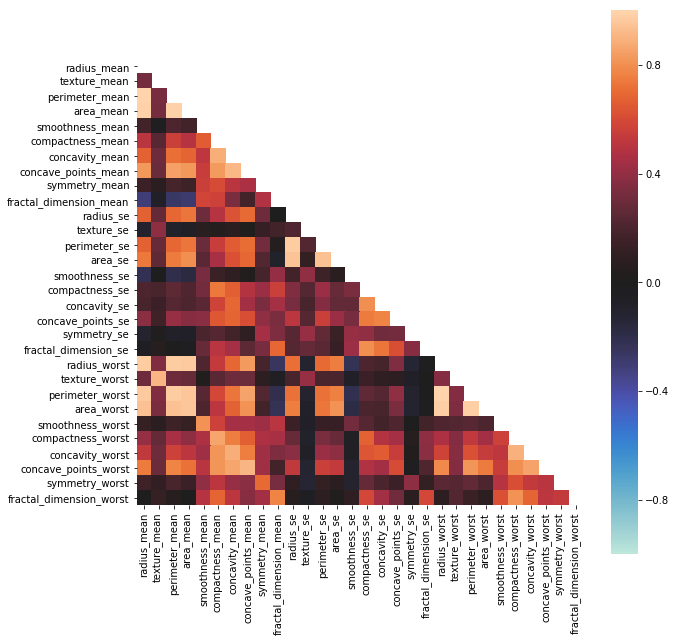

In [44]:
corr = data.iloc[:, 1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask=mask,vmax=1, vmin=-1,center=0, square=True);

There is a correlation between features from different features groups, e.g. radius_mean is correlated with area_mean and perimeter_mean.

Now I'd like to vizualize the data on a plane. I use PCA for that.

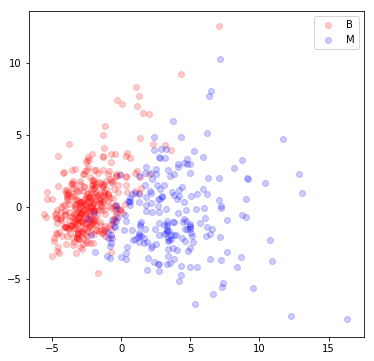

In [83]:
X = np.array(data.iloc[:, 1:])
target = data['target'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
plt.figure(figsize=(6, 6))
plt.scatter(X_pca[target == 'B', 0], X_pca[target == 'B', 1], color='red', alpha=0.2, label='B')
plt.scatter(X_pca[target == 'M', 0], X_pca[target == 'M', 1], color='blue', alpha=0.2, label='M')
plt.legend();

Projected on the plane samples seem separable into two classes with good quality so I think the samples can be classified with good quality. 

<b>Answer 1</b>
    1. The target classes are imbalanced.
    2. There are correlated features.
    3. There are irrelevant features.
    4. The features have different scales.
    5. 2D projection of the data seems separable.
I think the data can be classified well but some feature engineering is required in order to do that.    

### Classification (Answer 2)

In [46]:
y = data['target'].replace(['B', 'M'], [0, 1]).values
X = np.array(data.iloc[:, 1:])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

The target is imbalanced so I will use not only accuracy (the data is not highly imbalanced so it's ok to use the accuracy score) but also precision, recall and f1 scores to evaluate my classifiers.

In [48]:
scoring = ['precision', 'recall', 'f1', 'accuracy']

####  Baseline

As a baseline solution I'd like to use RandomForestClassifier because it doesn't require features to be the same scale or uncorrelated.

In [49]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_baseline = rf.predict(X_test)

In [50]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)

In [51]:
def print_test_scores(y_test, y_pred):
    print('Test Accuracy {:.5}\nTest F1 {:.5}\nTest Precision {:.5}\nTest Recall {:.5}\n'.format(accuracy_score(y_test, y_pred),
                                                                                                 f1_score(y_test, y_pred),
                                                                                                 precision_score(y_test, y_pred),
                                                                                                 recall_score(y_test, y_pred),
                                                                                                ))

In [52]:
print_test_scores(y_test, y_pred_baseline)

Test Accuracy 0.95105
Test F1 0.92929
Test Precision 1.0
Test Recall 0.86792



Let's evaluate the classifier using stratified 10-fold cross-validation.

In [53]:
baseline_scores = cross_validate(RandomForestClassifier(random_state=42),
                                 X_train,
                                 y_train,
                                 scoring=scoring,
                                 cv=StratifiedKFold(10),
                                 return_train_score=False)

In [54]:
def print_cv_scores(scores):
    print("CV Accuracy score: {:.5} ± {:.5}\nCV F1 score: {:.5} ± {:.5}\nCV Precision score: {:.5} ± {:.5}\nCV Recall score: {:.5} ± {:.5}".format(np.mean(scores['test_accuracy']),
                                                                                                                                                   np.std(scores['test_accuracy']),
                                                                                                                                                   np.mean(scores['test_f1']),
                                                                                                                 np.std(scores['test_f1']),
                                                                                                                 np.mean(scores['test_precision']),
                                                                                                                 np.std(scores['test_precision']),
                                                                                                                 np.mean(scores['test_recall']),
                                                                                                                 np.std(scores['test_recall'])) 
     )

In [55]:
print_cv_scores(baseline_scores)

CV Accuracy score: 0.96473 ± 0.0284
CV F1 score: 0.952 ± 0.038034
CV Precision score: 0.96833 ± 0.042254
CV Recall score: 0.9375 ± 0.048412


It can be seen that cross-validated scores are quite high.
On test data ability of the classifier to find all positive samples is lower (test recall=0.86) but all four metrics on test data are quite good.

#### Random Forest

As I've mentioned before some features seem irrelevant, so I think  feature selection can improve quality of the classifier. I will use univariate feature selection.

In [56]:
mean_scores_f1 = []
std_scores_f1 = []
mean_scores_precision = []
std_scores_precision = []
mean_scores_recall = []
std_scores_recall = []

mean_scores_accuracy = []
std_scores_accuracy = []

percentiles = np.arange(10, 101, 10)
for percentile in percentiles:
    clf = make_pipeline(SelectPercentile(mutual_info_classif, percentile=percentile),
                        RandomForestClassifier(random_state=42))
    scores = cross_validate(clf, X_train, y_train, scoring=scoring,
                                  cv=StratifiedKFold(10),
                                  return_train_score=False)
    mean_scores_f1.append(np.mean(scores['test_f1']))
    std_scores_f1.append(np.std(scores['test_f1']))
    
    mean_scores_precision.append(np.mean(scores['test_precision']))
    std_scores_precision.append(np.std(scores['test_precision']))
    
    mean_scores_recall.append(np.mean(scores['test_recall']))
    std_scores_recall.append(np.std(scores['test_recall']))
    
    mean_scores_accuracy.append(np.mean(scores['test_accuracy']))
    std_scores_accuracy.append(np.std(scores['test_accuracy']))

In [57]:
def plot_cv_scores(x_values, xlabel,
                   mean_scores_f1, std_scores_f1,
                   mean_scores_precision, std_scores_precision,
                   mean_scores_recall, std_scores_recall,
                   mean_scores_accuracy, std_scores_accuracy):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18,5), sharey=True)
    ax1.plot(x_values, mean_scores_f1)
    ax1.errorbar(x_values, mean_scores_f1, yerr=std_scores_f1, linestyle="None")

    ax2.plot(x_values, mean_scores_precision)
    ax2.errorbar(x_values, mean_scores_precision, yerr=std_scores_precision, linestyle="None")

    ax3.plot(x_values, mean_scores_recall)
    ax3.errorbar(x_values, mean_scores_recall, yerr=std_scores_recall, linestyle="None")
    
    ax4.plot(x_values, mean_scores_accuracy)
    ax4.errorbar(x_values, mean_scores_accuracy, yerr=std_scores_accuracy, linestyle="None")
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlabel(xlabel)
    ax1.set_ylabel('F1')
    ax2.set_ylabel('Precision')
    ax3.set_ylabel('Recall')
    ax4.set_ylabel('Accuracy');

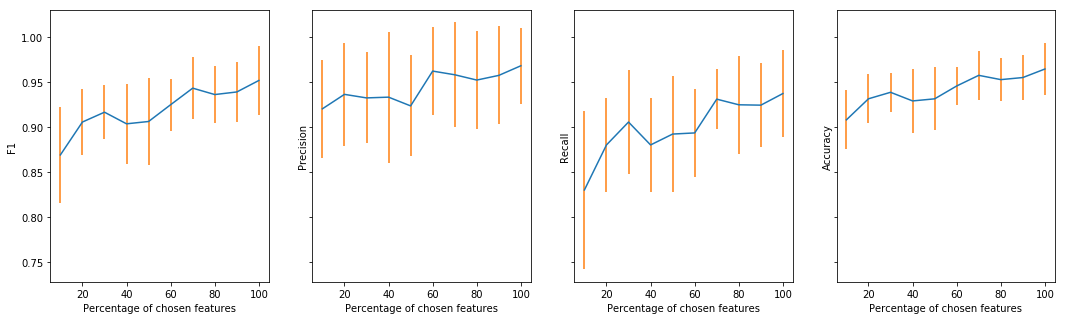

In [58]:
plot_cv_scores(percentiles, 'Percentage of chosen features',
               mean_scores_f1, std_scores_f1,
               mean_scores_precision, std_scores_precision,
               mean_scores_recall, std_scores_recall,
               mean_scores_accuracy, std_scores_accuracy)

According to the plots it can't be said that univariate feature selection improves quality of classifier. But I'd like to try pipeline which includes SelectPercentile and RandomForestClassifier and tune its hyperparameters using stratified 10-fold cross-validation.

In [59]:
pipe_rf = Pipeline([('select_features', SelectPercentile(mutual_info_classif)),
                  ('classify', RandomForestClassifier(random_state=42))])
percentile_range = np.arange(50, 101, 10)
n_estimators_range = np.arange(10, 101, 10)
max_depth_range = [3, 5, 7]

param_grid = [
    {
        'select_features__percentile': percentile_range,
        'classify__n_estimators': n_estimators_range,
        'classify__max_depth': max_depth_range
        
    }
]
grid = GridSearchCV(pipe_rf, cv=StratifiedKFold(10), n_jobs=-1, param_grid=param_grid, scoring='f1')
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select_features', SelectPercentile(percentile=10,
         score_func=<function mutual_info_classif at 0x1172b2d08>)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            m...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'select_features__percentile': array([ 50,  60,  70,  80,  90, 100]), 'classify__n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 'classify__max_depth': [3, 5, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [60]:
print('{:.5}'.format(grid.best_score_))

0.95582


CV F1 score of the best estimator by GridSearch is slightly higher than CV F1 score of the baseline estimator (0.95582 vs 0.952).

In [61]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('select_features', SelectPercentile(percentile=100,
         score_func=<function mutual_info_classif at 0x1172b2d08>)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min...stimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

Let's evaluate the best estimator using stratified 10-fold cross-validation.

In [62]:
cv_scores_rf = cross_validate(grid.best_estimator_, X_train, y_train, scoring=scoring, cv=StratifiedKFold(10), return_train_score=False)
print_cv_scores(cv_scores_rf)

CV Accuracy score: 0.96699 ± 0.021619
CV F1 score: 0.95565 ± 0.029049
CV Precision score: 0.96282 ± 0.040224
CV Recall score: 0.95 ± 0.0375


In [63]:
#baseline cv scores
print_cv_scores(baseline_scores)

CV Accuracy score: 0.96473 ± 0.0284
CV F1 score: 0.952 ± 0.038034
CV Precision score: 0.96833 ± 0.042254
CV Recall score: 0.9375 ± 0.048412


So the best estimator has higher accuracy, f1 and recall scores and lower precision score. Looking at standard deviations for those scores it can be said that difference in scores between the baseline estimator and the best estimator is not very significant.

Let's try the best estimator on test data.

In [64]:
grid.best_estimator_.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('select_features', SelectPercentile(percentile=100,
         score_func=<function mutual_info_classif at 0x1172b2d08>)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min...stimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [65]:
y_pred_best_rf = grid.best_estimator_.predict(X_test)

In [66]:
print_test_scores(y_test, y_pred_best_rf)

Test Accuracy 0.96503
Test F1 0.9505
Test Precision 1.0
Test Recall 0.90566



In [67]:
def print_baseline_test_scores():
    print('Baseline test Accuracy {:.5}\nBaseline test F1 {:.5}\nBaseline test Precision {:.5}\nBaseline test Recall {:.5}\n'.format(baseline_accuracy,
                                                                                                                                 baseline_f1,
                                                                                                                                 baseline_precision,
                                                                                                                                 baseline_recall))

In [68]:
print_baseline_test_scores()

Baseline test Accuracy 0.95105
Baseline test F1 0.92929
Baseline test Precision 1.0
Baseline test Recall 0.86792



On test data the best estimator has better scores than the baseline estimator.

####  SVM

When the samples are projected on a plane using PCA, it seems that classes can be separated with good quality by a single line. So I've decided to try SVM. The features have different scales, there are some features that seem irrelavent and some correlated features, so I use StandardScaler to scale and PCA to reduce and transform features before classification.

In [69]:
scoring = ['precision', 'recall', 'f1', 'accuracy']
clf = make_pipeline(StandardScaler(), PCA(n_components=2, whiten=True), SVC())
scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=StratifiedKFold(10), return_train_score=False)
print_cv_scores(scores)

CV Accuracy score: 0.92469 ± 0.034907
CV F1 score: 0.89648 ± 0.045703
CV Precision score: 0.93104 ± 0.069156
CV Recall score: 0.86792 ± 0.051876


Scores are lower than the baseline scores.
Let's try this classifier on test data.

In [70]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [71]:
print('Test Accuracy {:.5}\nTest F1 {:.5}\nTest Precision {:.5}\nTest Recall {:.5}'.format(accuracy_score(y_test, y_pred),
                                                                                           f1_score(y_test, y_pred),
                                                                                           precision_score(y_test, y_pred),
                                                                                           recall_score(y_test, y_pred)))

Test Accuracy 0.94406
Test F1 0.92
Test Precision 0.97872
Test Recall 0.86792


In [72]:
print_baseline_test_scores()

Baseline test Accuracy 0.95105
Baseline test F1 0.92929
Baseline test Precision 1.0
Baseline test Recall 0.86792



On test data scores are also lower.

I use stratified 10-foldcross-validation to see how a number of components for PCA affect metrics.

In [73]:
n_components_range = np.arange(2, 31)
mean_scores_f1 = []
std_scores_f1 = []
mean_scores_precision = []
std_scores_precision = []
mean_scores_recall = []
std_scores_recall = []
mean_scores_accuracy = []
std_scores_accuracy = []
for n_components in n_components_range:
    clf = make_pipeline(StandardScaler(), PCA(whiten=True, n_components=n_components), SVC())
    scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=StratifiedKFold(10), return_train_score=False)
    mean_scores_f1.append(np.mean(scores['test_f1']))
    std_scores_f1.append(np.std(scores['test_f1']))
    
    mean_scores_precision.append(np.mean(scores['test_precision']))
    std_scores_precision.append(np.std(scores['test_precision']))
    
    mean_scores_recall.append(np.mean(scores['test_recall']))
    std_scores_recall.append(np.std(scores['test_recall']))
    
    mean_scores_accuracy.append(np.mean(scores['test_accuracy']))
    std_scores_accuracy.append(np.std(scores['test_accuracy']))

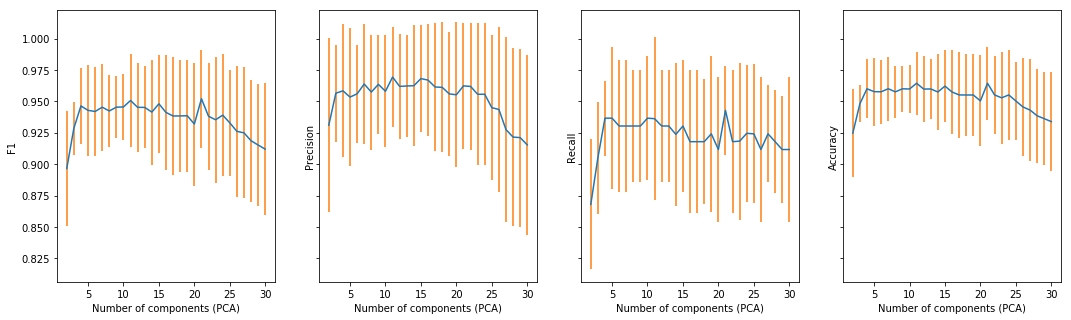

In [74]:
plot_cv_scores(n_components_range, 'Number of components (PCA)',
               mean_scores_f1, std_scores_f1,
               mean_scores_precision, std_scores_precision,
               mean_scores_recall, std_scores_recall,
               mean_scores_accuracy, std_scores_accuracy)

Feature dimensionality reduction improves quality of classification.

I tune number of components of PCA and hyperparameters of SVM with grid search cross-validation.

In [75]:
%%time
n_components_range = np.arange(3, 25).astype(int)
c_range = [1, 10, 100, 1000]

svm_pipe = Pipeline([('scale', StandardScaler()), ('reduce_dim', PCA()), ('classify', SVC())])

tuned_parameters = [{'reduce_dim__n_components': n_components_range,
                     'classify__kernel': ['rbf'],
                     'classify__gamma': [1e-3, 1e-4],
                     'classify__C': c_range},
                    {'reduce_dim__n_components': n_components_range,
                     'classify__kernel': ['linear'],
                     'classify__C': c_range}]
grid = GridSearchCV(svm_pipe, tuned_parameters, cv=StratifiedKFold(10), scoring='f1')
grid.fit(X_train, y_train)

CPU times: user 1min 4s, sys: 336 ms, total: 1min 5s
Wall time: 1min 4s


In [76]:
grid.best_score_

0.9743973698823768

In [77]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=11, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Let's evaluate the best SVM classifier using cross-validation.

In [78]:
cv_scores_svm = cross_validate(grid.best_estimator_, X_train, y_train, scoring=scoring, cv=StratifiedKFold(10), return_train_score=False)
print_cv_scores(cv_scores_svm)

CV Accuracy score: 0.98106 ± 0.017951
CV F1 score: 0.97418 ± 0.024179
CV Precision score: 0.98708 ± 0.02585
CV Recall score: 0.96208 ± 0.030982


In [79]:
#best random forest cv scored
print_cv_scores(cv_scores_rf)

CV Accuracy score: 0.96699 ± 0.021619
CV F1 score: 0.95565 ± 0.029049
CV Precision score: 0.96282 ± 0.040224
CV Recall score: 0.95 ± 0.0375


Cross-validated scores are higher than cross-validated scores for the best RandomForestClassifier. Let's try it on test data.

In [80]:
grid.best_estimator_.fit(X_train, y_train)
y_pred_best_svm = grid.best_estimator_.predict(X_test)
print_test_scores(y_test, y_pred_best_svm)

Test Accuracy 0.97203
Test F1 0.96154
Test Precision 0.98039
Test Recall 0.9434



In [81]:
#best radom forest test scores
print_test_scores(y_test, y_pred_best_rf)

Test Accuracy 0.96503
Test F1 0.9505
Test Precision 1.0
Test Recall 0.90566



In [82]:
print_baseline_test_scores()

Baseline test Accuracy 0.95105
Baseline test F1 0.92929
Baseline test Precision 1.0
Baseline test Recall 0.86792



All scores except precision are higher for the best SVM classifier in comparison with the best Random Forest classifier and the baseline classifier.

I think the best classifier is the best SVM classifier because it has the highest accuracy and the highest f1. Accuracy and f1 say more about quality of classifier than just precision.

## Missing values (Answer 3)

There are different ways to handle missing values.
<br>
Firstly, I'd make a binary feature from a feature with missing values (1 - value is missing, 0 - value is not missing) to see if there are any relationships between missing values and other features and target. If there are few missing values and they seem random, I'd consider to drop samples with missing features. 
<br>
Then I'd try different imputation techniques. If the feature with missing values is categorical, missing values can be replaced to some special value (especially if missing values are missing not at random and it's important to keep information that value is missing) or to the most common value. If the feature is continious it can be replaced to some special value (when it's important to keep information that value is missing) or to mean or median of the featire values. Sometimes missing values can be filled using some domain knowledge.
<br>
Also it may be worth trying to predict values of missing values. K-nearest neigbour algorithm can be used for that.
<br>
I'd try different ways handle missing values and I'd compare those ways using cross-validation.